In [1]:
import torch
import os
from torch import nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import torch.nn.functional as F
from PIL import Image
from matplotlib import pyplot as plt

In [2]:
latent_dim = 100
lr = 0.0002
batch_size = 128
image_channels = 1
num_epochs = 50
OUTPUT_DIR = "./data/dcgan"

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# MNIST dataset
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [4]:
if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, image_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        return self.main(z.view(-1, latent_dim, 1, 1))

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (1) x 32 x 32
            nn.Conv2d(image_channels, 128, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # State size. (128) x 16 x 16
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # State size. (256) x 8 x 8
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # State size. (512) x 4 x 4
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            # State size. 1
        )

    def forward(self, img):
        return self.main(img).view(-1, 1)

In [7]:
# Initialize models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Optimizers
d_optimizer = optim.Adam(discriminator.parameters(), lr=1e-4)
g_optimizer = optim.Adam(generator.parameters(), lr=1e-4)

# Loss function
criterion = nn.BCELoss()

In [8]:
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(train_loader):
        # Process real images
        real_images = images.to(device)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train Discriminator
        d_optimizer.zero_grad()
        real_loss = criterion(discriminator(real_images), real_labels)
        z = torch.randn(batch_size, latent_dim, 1, 1).to(device)
        fake_images = generator(z)
        fake_loss = criterion(discriminator(fake_images.detach()), fake_labels)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        g_optimizer.zero_grad()
        g_loss = criterion(discriminator(fake_images), real_labels)
        g_loss.backward()
        g_optimizer.step()

        if (i + 1) % 400 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], D Loss: {d_loss.item()}, G Loss: {g_loss.item()}')

    save_image(fake_images.data, f'{OUTPUT_DIR}/fake_image-{epoch+1:03d}.png', normalize=True)

Epoch [1/50], Step [400/468], D Loss: 0.00045006503933109343, G Loss: 8.471490859985352
Epoch [2/50], Step [400/468], D Loss: 9.682246309239417e-05, G Loss: 10.082169532775879
Epoch [3/50], Step [400/468], D Loss: 5.9884296206291765e-05, G Loss: 12.075471878051758
Epoch [4/50], Step [400/468], D Loss: 0.00038652532384730875, G Loss: 9.847955703735352
Epoch [5/50], Step [400/468], D Loss: 0.03887809067964554, G Loss: 5.367314338684082
Epoch [6/50], Step [400/468], D Loss: 0.01872333139181137, G Loss: 6.085550308227539
Epoch [7/50], Step [400/468], D Loss: 0.10506810247898102, G Loss: 3.2203454971313477
Epoch [8/50], Step [400/468], D Loss: 0.038218412548303604, G Loss: 8.058674812316895
Epoch [9/50], Step [400/468], D Loss: 0.08484627306461334, G Loss: 4.088262557983398
Epoch [10/50], Step [400/468], D Loss: 0.12405479699373245, G Loss: 3.6095995903015137
Epoch [11/50], Step [400/468], D Loss: 0.07353244721889496, G Loss: 4.205303192138672
Epoch [12/50], Step [400/468], D Loss: 0.357803

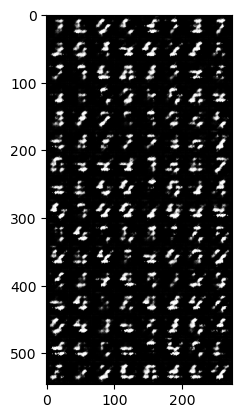

In [10]:
image = Image.open(f'{OUTPUT_DIR}/fake_image-005.png')
plt.imshow(image)
plt.show()

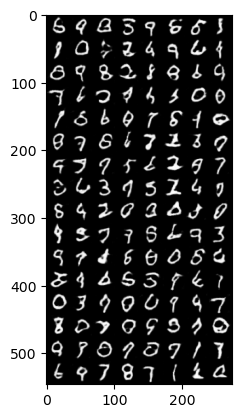

In [11]:
image = Image.open(f'{OUTPUT_DIR}/fake_image-010.png')
plt.imshow(image)
plt.show()

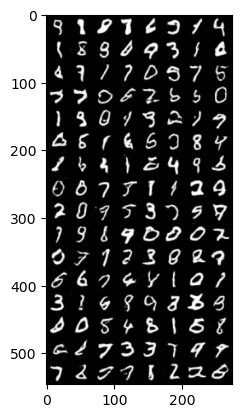

In [12]:
image = Image.open( f'{OUTPUT_DIR}/fake_image-015.png')
plt.imshow(image)
plt.show()

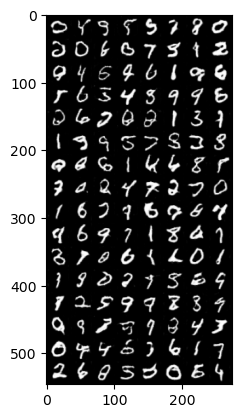

In [13]:
image = Image.open( f'{OUTPUT_DIR}/fake_image-020.png')
plt.imshow(image)
plt.show()

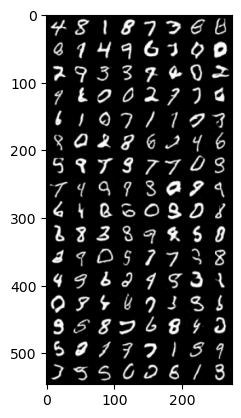

In [14]:
image = Image.open( f'{OUTPUT_DIR}/fake_image-025.png')
plt.imshow(image)
plt.show()

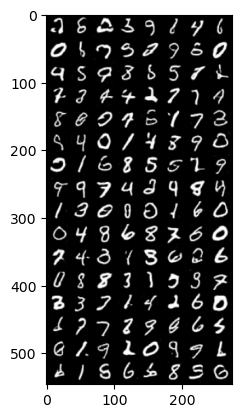

In [15]:
image = Image.open(f'{OUTPUT_DIR}/fake_image-029.png')
plt.imshow(image)
plt.show()